# Hydrogen gas molecule dissociation


**Reference solution**

In [1]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from basistool import compute_integrals
from tqdm import tqdm

In [2]:
# Integrals
margin = 2.0
dists = np.geomspace(0.7, 8.0, 40)
datas = []
for dist in tqdm(dists):
    zgrid = np.arange(-dist / 2 - margin, dist / 2 + margin, 0.02)
    points = np.zeros((len(zgrid), 3))
    points[:, 2] = zgrid
    data = compute_integrals(
        ["H", "H"], [[0.0, 0.0, -dist / 2], [0.0, 0.0, dist / 2]], "aug-cc-pvdz.gbs", points
    )
    datas.append(data)

100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


In the following cell, all lines that end with a `# RHF` comment contain RHF-specific code.

In [3]:
def solve_rhf():
    for dist, data in zip(tqdm(dists), datas, strict=False):
        # Get a few operators.
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]
        data["hcore"] = coreham
        
        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)  # RHF

        # The scf cycle (See 02_helium.ipynb for details.)
        for _scf_counter in range(500):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + 2 * hartree - exchange  # Specific for RHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + hartree - 0.5 * exchange  #  RHF
        electronic_energy = 2 * np.einsum("ij,ji", ham, dm)  # RHF

        # Compute the occupied orbital on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # RHF

        # Store results back into the data dictionary.
        # (Mind the two electrons.)
        data["eigvals_rhf"] = eigvals
        data['eigvecs_rhf'] = eigvecs
        data["energy_rhf"] = electronic_energy + 1 / dist
        data["density_rhf"] = 2 * psi0**2  # RHF


solve_rhf()

100%|██████████| 40/40 [00:00<00:00, 475.60it/s]


In the following cell, all lines that end with a `# UHF` comment contain UHF-specific code.

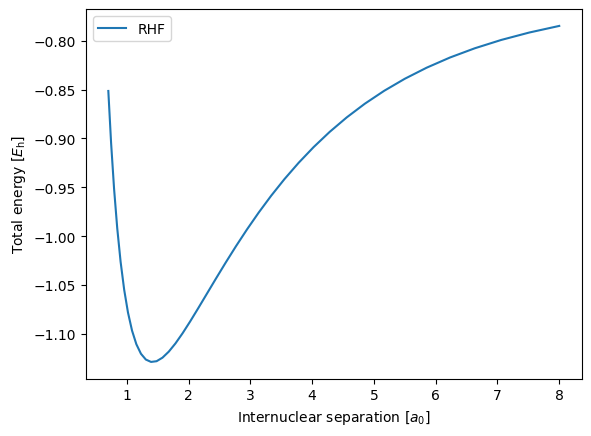

In [4]:
def plot_energy():
    plt.close("dissoc")
    _fig, ax = plt.subplots(num="dissoc")
    ax.plot(dists, [data["energy_rhf"] for data in datas], label="RHF")
    ax.set_xlabel(r"Internuclear separation [$a_0$]")
    ax.set_ylabel(r"Total energy [$E_\mathrm{h}$]")
    ax.legend()


plot_energy()

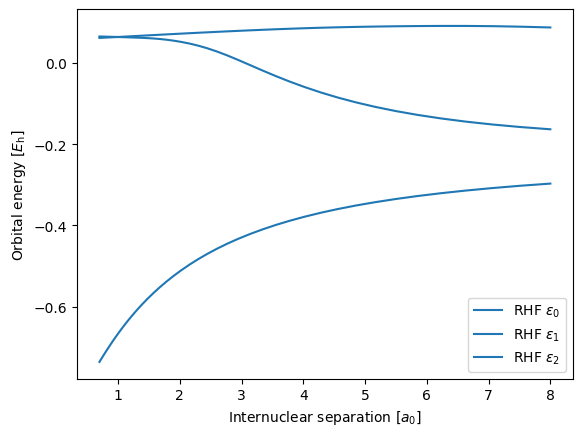

In [5]:
def plot_eigvals():
    plt.close("eigvals")
    _fig, ax = plt.subplots(num="eigvals")
    for ieval in range(3):
        ax.plot(
            dists,
            [data["eigvals_rhf"][ieval] for data in datas],
            label=rf"RHF $\epsilon_{ieval}$",
            color="C0",
        )
    
    ax.set_xlabel(r"Internuclear separation [$a_0$]")
    ax.set_ylabel(r"Orbital energy [$E_\mathrm{h}$]")
    ax.legend()


plot_eigvals()

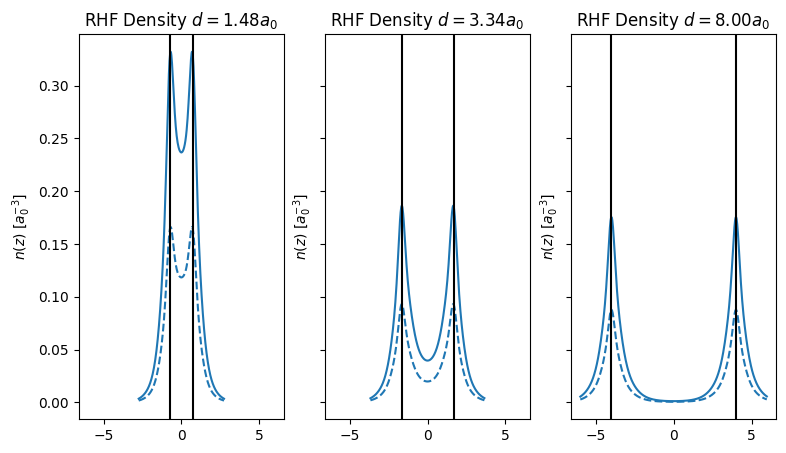

In [6]:
def plot_densities():
    def plot_dens(ax0, i):
        data = datas[i]
        dist = dists[i]

        ax0.set_title(f"RHF Density $d={dist:.2f} a_0$")
        ax0.plot(data["points"][:, 2], data["density_rhf"], "C0-", label="RHF")
        ax0.plot(data["points"][:, 2], data["density_rhf"] / 2, "C0--")
        ax0.axvline(-dist / 2, color="k")
        ax0.axvline(dist / 2, color="k")
        ax0.set_ylabel("$n(z)$ [$a_0^{-3}$]")

    plt.close("densities")
    _fig, axs = plt.subplots(1, 3, num="densities", figsize=(9, 5), sharex=True, sharey=True)
    plot_dens(axs[0], dists.searchsorted(1.4))
    plot_dens(axs[1], dists.searchsorted(3.2))
    plot_dens(axs[2], len(dists) - 1)


plot_densities()

In [14]:
# choose equilibrium geometry index keq (e.g., the minimum in your scan)
keq = int(np.argmin([d["energy_rhf"] for d in datas]))
data = datas[keq]
C = data["eigvecs_rhf"]      # AO -> MO coefficients (columns = MOs)
bfs = data["bfs"]            # AO basis functions on grid points (from your code)
zgrid = data["density_rhf"]*0 + data["density_rhf"]  # just to get shape if needed

# Build the two lowest spatial MOs on your grid
psi0 = C[:, 0] @ data["bfs"]   # bonding candidate (σg)
psi1 = C[:, 1] @ data["bfs"]   # antibonding candidate (σu)

# Qualitative checks:
# - σg should have no node between nuclei; σu should have one nodal plane at the midpoint.
mid_idx = np.argmin(np.abs(data["points"][:,2]))  # nearest to z=0
print("psi0 midpoint value:", psi0[mid_idx])
print("psi1 midpoint value:", psi1[mid_idx])
# Expect psi0 midpoint large (same sign lobes), psi1 midpoint ~0 with sign change across z=0.

psi0 midpoint value: 0.36181446857056276
psi1 midpoint value: 0.0002566084641474197


In [22]:
import numpy as np

# build psi for MO index `mo_idx`
def build_psi(data, C, mo_idx):
    # C: (n_AO, n_MO). bfs: (n_AO, n_points)
    coef = C[:, mo_idx]            # (n_AO,)
    psi = coef @ data["bfs"]       # (n_points,)
    rho = psi**2
    return psi, rho

psi0, rho0 = build_psi(data, C, 0)
psi1, rho1 = build_psi(data, C, 1)

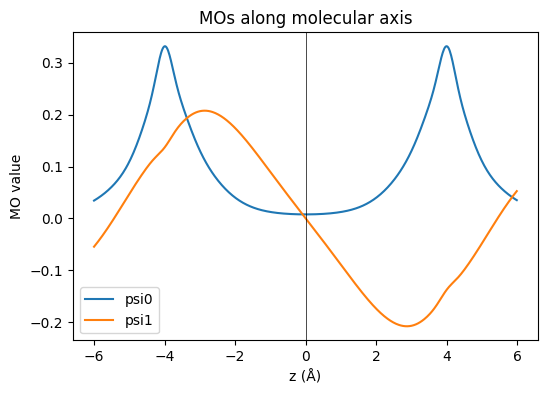

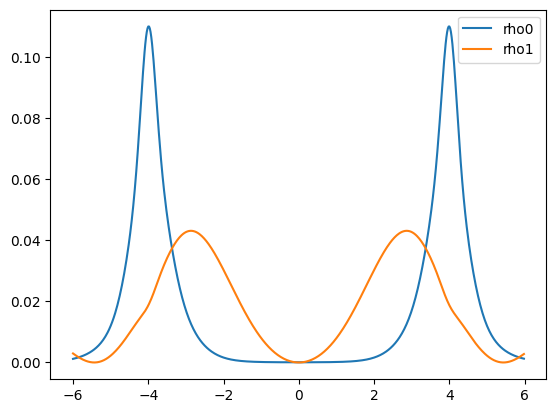

In [25]:
import matplotlib.pyplot as plt

points = data["points"]  # (n_points,3)
x, y, z = points.T

# choose points near the axis (radius threshold)
r = np.sqrt(x**2 + y**2)
mask = r < 0.15  # tune threshold to your geometry / grid spacing
idx = np.where(mask)[0]
order = np.argsort(z[idx])
z_line = z[idx][order]

plt.figure(figsize=(6,4))
plt.plot(z_line, psi0[idx][order], label="psi0")
plt.plot(z_line, psi1[idx][order], label="psi1")
plt.axvline(0, color='k', lw=0.5)
plt.xlabel("z (Å)")
plt.ylabel("MO value")
plt.legend()
plt.title("MOs along molecular axis")
plt.show()

# If you prefer densities:
plt.figure()
plt.plot(z_line, rho0[idx][order], label="rho0")
plt.plot(z_line, rho1[idx][order], label="rho1")
#plt.yscale("log")  # optional
plt.legend()
plt.show()

In [ ]:
import numpy as np

def ao_to_mo_2orb(data):
    C = data["eigvecs_rhf"][:, :2]   # keep 2 lowest MOs, only used potentially occupied ones
    h_ao = data["hcore"]
    eri_ao = data["eri"]             # chemists' notation (μν|λσ)
    h = C.T @ h_ao @ C
    g = np.einsum("pqrs,pi,qj,rk,sl->ijkl", eri_ao, C, C, C, C, optimize=True)
    return h, g

h, g = ao_to_mo_2orb(data)

In [ ]:
def ci_block_singlet_2orb(h, g):
    h00, h11 = h[0,0], h[1,1] # h is one body operator in MO basis
    h01 = h[0,1] # off diagonal one body term

    g0000 = g[0,0,0,0] #g is two body operator in MO basis
    g1111 = g[1,1,1,1]
    g0011 = g[0,0,1,1]
    g0110 = g[0,1,1,0]
    g0101 = g[0,1,0,1]
    g0001 = g[0,0,0,1]
    g0111 = g[0,1,1,1]

    H = np.zeros((3,3))
    # Diagonal elements (Coulomb + exchange + one-electron):

    H[0,0] = 2*h00 + g0000     # expection value of ref ref, two electrons in ground state so 2*h00 + hartree

    H[1,1] = h00 + h11 + g0101 #- g0110 #Coulomb, no exchange because oposite spins (1 electron in reference and one excited, needs to have differnet spins to form singlet)
    H[2,2] = 2*h11 + g1111 #hartree of both electrons in excited orbital
    
    # Off-diagonals (couplings by one- and two-electron terms):
    H[0,1] = H[1,0] = np.sqrt(2) * (h01 + g0001)

    H[1,2] =  H[2,1] = np.sqrt(2) * (h01 + g0111) # coupling between single excitations and double excitations
    H[0,2] = H[2,0] =  g0011 #- g0110 no exchange subtraction for opposite spins otherwise no singlet
    # H[1,2] = H[2,1] = H[0,1] = H[1,0] = 0  # no direct coupling between ref and singles in minimal basis because of symmetry parity rule
    return H
#explain parity rules via symmetry of integrals
H = ci_block_singlet_2orb(h, g)
print("CI Hamiltonian matrix (Ha):\n", H)
eigvals, eigvecs = np.linalg.eigh(H)
E_elec = eigvals[0]               # lowest singlet CI electronic energy
E_tot = E_elec + 1.0 / dists[keq] # add nuclear repulsion
print("Singlet CI eigenvalues (Ha):", eigvals)
print("CI ground-state total energy (Ha):", E_tot)
print("RHF total energy at this R (Ha):", data["energy_rhf"])

CI Hamiltonian matrix (Ha):
 [[-1.84733706e+00 -2.71717649e-16  5.33982770e-03]
 [-2.71717649e-16 -1.36506173e+00 -4.86055752e-14]
 [ 5.33982770e-03 -4.86055752e-14 -4.26363171e-01]]
Singlet CI eigenvalues (Ha): [-1.84735712 -1.36506173 -0.4263431 ]
CI ground-state total energy (Ha): -1.1287459323072473
RHF total energy at this R (Ha): -1.128725866240242


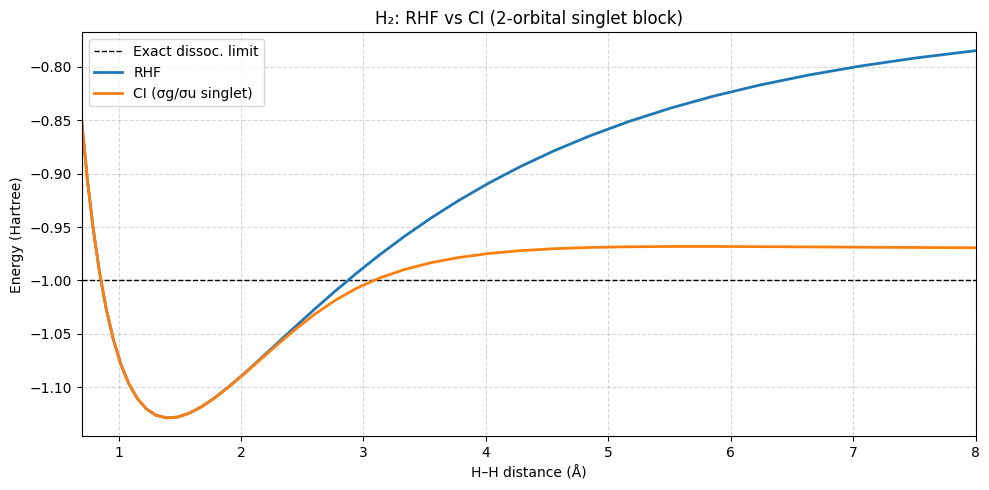

In [52]:
E_rhf = []
E_ci  = []

for R, data in zip(dists, datas, strict=False):
    # RHF total energy was stored as energy_rhf (already includes nuclear repulsion)
    E_rhf.append(data["energy_rhf"])

    # CI (3×3 singlet block)
    h, g = ao_to_mo_2orb(data)
    H = ci_block_singlet_2orb(h, g)
    eigvals, _ = np.linalg.eigh(H)
    E_ci.append(eigvals[0] + 1.0 / R)  # add nuclear repulsion

E_rhf = np.array(E_rhf)
E_ci  = np.array(E_ci)

# --- Plot ---

plt.figure(figsize=(10,5))
plt.xlim(dists[0], dists[-1])
plt.hlines(-1.0, dists[0], dists[-1], colors="k", linestyles="--", lw=1, label="Exact dissoc. limit")
plt.plot(dists, E_rhf, label="RHF", lw=2)
plt.plot(dists, E_ci,  label="CI (σg/σu singlet)", lw=2)
plt.xlabel("H–H distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂: RHF vs CI (2-orbital singlet block)")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("rhf_vs_ci.png", dpi=200)
plt.show()

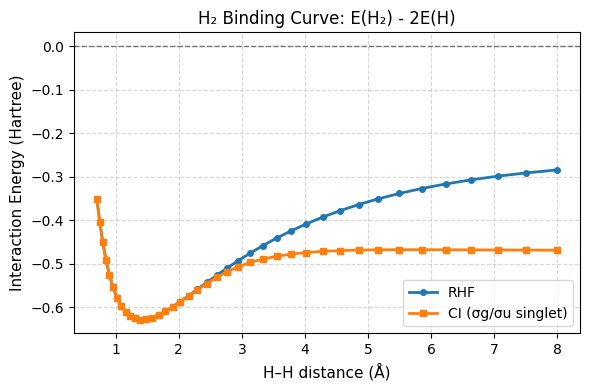


RHF Results:
  Equilibrium distance:  1.392 Å
  Binding energy: -0.628726 Ha

CI Results:
  Equilibrium distance: 1.392 Å
  Binding energy: -0.628746 Ha

Experimental H₂:
  Equilibrium distance: 0.741 Å
  Binding energy:  ~0.1745 Ha


In [ ]:
# Calculate interaction energies (binding curves)
# E(H) is the dissociation limit:  take the energy at largest R as approximation
E_H_rhf = E_rhf[-1] #/ 2  # RHF: E(2H) at infinite separation divided by 2
E_H_ci = E_ci[-1] #/ 2    # CI: E(2H) at infinite separation divided by 2

# Interaction energies
ΔE_rhf = E_rhf +  0.5
ΔE_ci = E_ci +0.5

# --- Plot interaction energies ---
plt.figure(figsize=(6, 4))

plt.plot(dists, ΔE_rhf, label="RHF", lw=2, marker='o', markersize=4)
plt.plot(dists, ΔE_ci, label="CI (σg/σu singlet)", lw=2, marker='s', markersize=4)
plt.axhline(0, color='black', ls='--', lw=1, alpha=0.5)
plt.xlabel("H–H distance (Å)", fontsize=11)
plt.ylabel("Interaction Energy (Hartree)", fontsize=11)
plt.title("H₂ Binding Curve: E(H₂) - 2E(H)", fontsize=12)
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.hline()
plt.tight_layout()
plt.savefig("h2_interaction_energy.png", dpi=200)
plt.show()

# --- Print binding energies and equilibrium distances ---
idx_min_rhf = np.argmin(ΔE_rhf)
idx_min_ci = np. argmin(ΔE_ci)

print("\n" + "="*50)
print("RHF Results:")
print(f"  Equilibrium distance:  {dists[idx_min_rhf]:.3f} Å")
print(f"  Binding energy: {ΔE_rhf[idx_min_rhf]:.6f} Ha")

print("\nCI Results:")
print(f"  Equilibrium distance: {dists[idx_min_ci]:.3f} Å")
print(f"  Binding energy: {ΔE_ci[idx_min_ci]:.6f} Ha")

print("\nExperimental H₂:")
print(f"  Equilibrium distance: 0.741 Å")
print(f"  Binding energy:  ~0.1745 Ha")
print("="*50)